# Analysis and Comparison of Supervised Methods by Classification on Hyperspectral Images

Hyperspectral imaging is a powerful technology that enables gathering detailed information about the composition and characteristics of objects and surfaces in a way that is impossible with conventional imaging systems.

Some fields where hypersectral imaging is useful are:

  - Agrculture
  - Mineral exploration
  - Environmental monitoring
  - Military surveillance

# Used methods

#### 1. Support vector machines
  
SVMs are a set of supervised learning methods used for classification, regression and outliers detection.

Advantages:
  - Effective in high dimensional spaces
  - Effective in cases where number of dimensions is greater than the number of samples
  - Uses a subset of training points in the decision function (called support vectors), so it is also memory efficient

Disadvantages:
  - If the number of features is much greater than the number of samples, avoid over-fitting in choosing Kernel functions and regularization term is crucial

  - SVMs do not directly provide probability estimates, these are calculated using an expensive five-fold cross-validation

#### 2. Random Forest

A random forest is a meta estimator that fits a number of decision tree classifiers on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting.

Advantages:
  - High Accuracy
  - Robustness to Noise
  - Handles Missing Data and Outliers

Disadvantages:
  - Comutationl Complexity
  - Memory Usage
  - Prediction Time
  - Overfitting

# 1) Install all modules

In [52]:
!pip install numpy pandas matplotlib kagglehub seaborn

Traceback (most recent call last):
  File "<frozen importlib._bootstrap>", line 688, in _load_unlocked
  File "<frozen importlib._bootstrap_external>", line 883, in exec_module
  File "<frozen importlib._bootstrap>", line 241, in _call_with_frames_removed
  File "/usr/local/lib/python3.10/dist-packages/pip/_vendor/requests/__init__.py", line 43, in <module>
    from pip._vendor import urllib3
  File "/usr/local/lib/python3.10/dist-packages/pip/_vendor/urllib3/__init__.py", line 13, in <module>
    from .connectionpool import HTTPConnectionPool, HTTPSConnectionPool, connection_from_url
  File "/usr/local/lib/python3.10/dist-packages/pip/_vendor/urllib3/connectionpool.py", line 13, in <module>
    from .connection import (
  File "/usr/local/lib/python3.10/dist-packages/pip/_vendor/urllib3/connection.py", line 15, in <module>
    from .util.proxy import create_proxy_ssl_context
  File "/usr/local/lib/python3.10/dist-packages/pip/_vendor/urllib3/util/__init__.py", line 8, in <module>
    

# Load dataset

Path to dataset files: /root/.cache/kagglehub/datasets/billbasener/hyperspectral-library-of-agricultural-crops-usgs/versions/1
   UniqueID Country  AEZ                          Image  Month  Year   jd  \
0      1466     USA    7  EO1H0440332012234110KD_SGS_01      8  2012  234   
1      1467     USA    7  EO1H0440332012234110KD_SGS_01      8  2012  234   
2      1469     USA    7  EO1H0440332012234110KD_SGS_01      8  2012  234   
3      1470     USA    7  EO1H0440332012234110KD_SGS_01      8  2012  234   
4      1476     USA    7  EO1H0440332012234110KD_SGS_01      8  2012  234   

         long        lat  Crop  ...     X2254     X2264     X2274     X2285  \
0 -121.663419  38.534516  corn  ...  8.432855  8.438398  8.585301  8.164735   
1 -121.671589  38.504744  corn  ...  8.682515  8.942595  9.179517  8.744633   
2 -121.597588  38.614056  corn  ...  6.841276  6.276240  6.150597  6.114164   
3 -121.687293  38.571702  corn  ...  6.679967  6.534779  6.430438  6.080465   
4 -121.625189  

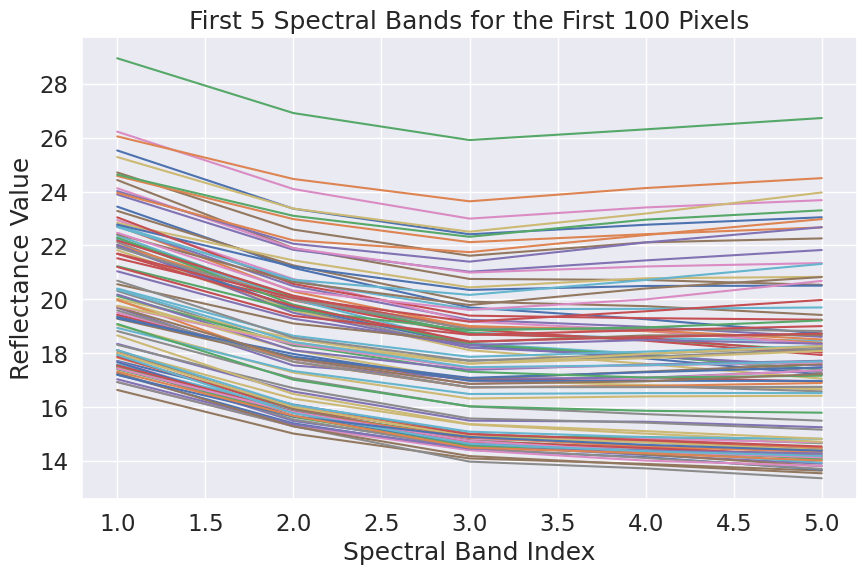

In [53]:
import kagglehub
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier

sns.set(font_scale=1.5)

# download latest version
path = kagglehub.dataset_download("billbasener/hyperspectral-library-of-agricultural-crops-usgs")
print("Path to dataset files:", path)

df = pd.read_csv(f"{path}/GHISACONUS_2008_001_speclib.csv")
print(df.head())

# create an aditional column
df["Class"] = df["Crop"] + "_" + df["Stage"]
print(df.head())

# print the first 5 spectral bands for the first 100 pixels

spectral_bands = [col for col in df.columns if col.startswith('X')]  # Filter spectral band columns
first_5_bands = spectral_bands[:5]  # select the first 5 bands

# extract the first 100 pixels for the first 5 bands
subset = df[first_5_bands].iloc[:100]
plt.figure(figsize=(10, 6))

for i in range(100):  # loop through the first 100 pixels
    plt.plot(range(1, 6), subset.iloc[i], label=f'Pixel {i + 1}')

# add labels and legend
plt.xlabel('Spectral Band Index')
plt.ylabel('Reflectance Value')
plt.title('First 5 Spectral Bands for the First 100 Pixels')
plt.grid(True)
plt.show()

# 2) Create Wavelength Columns list in order to keep track of every wavelength in our hyperspectral images

In [54]:
# wavelength columns
wl_list = []

for c in df.columns:
    if c[0]=='X': wl_list.append(c)
X = df[wl_list]
X.head()

,X437,X447,X457,X468,X478,X488,X498,X508,X518,X529,...,X2254,X2264,X2274,X2285,X2295,X2305,X2315,X2325,X2335,X2345
0,17.724022,16.105696,15.024523,14.715921,14.441503,14.166527,13.830132,13.708207,13.912823,14.214426,...,8.432855,8.438398,8.585301,8.164735,7.882625,7.380592,7.327904,6.881876,6.616288,6.346634
1,17.850463,15.999081,15.013466,14.782901,14.501259,14.257706,13.966769,13.921256,14.178185,14.571256,...,8.682515,8.942595,9.179517,8.744633,8.510454,8.090403,7.894839,7.263033,6.536649,5.663291
2,17.566144,15.844705,14.903485,14.906514,14.673835,14.297178,13.872969,13.699403,13.894069,14.166823,...,6.841276,6.276240,6.150597,6.114164,5.934033,5.116303,4.833205,4.817732,4.652525,3.790456
3,17.509762,15.825789,14.863198,14.759544,14.411682,14.147443,13.909676,13.831227,14.125468,14.545580,...,6.679967,6.534779,6.430438,6.080465,6.201545,6.291307,6.922908,6.943876,6.461839,5.696439
4,17.540088,15.498984,14.596975,14.237083,13.915319,13.491013,12.943444,12.584902,12.541382,12.657275,...,5.256362,5.022666,4.988447,5.220789,5.726055,6.007986,4.820400,3.084297,1.322807,1.087548


# 3) Normalize data using Standard Scaler

In [55]:
X1 = StandardScaler().fit_transform(X)
Y = df["Class"]

# 4) Split the test dataset

In [56]:
x_train, x_test, y_train, y_test = train_test_split(X1,Y,test_size=0.20, random_state = 0)

# 5) Use SVM approach

In [61]:
SVM_model = SVC( C = 1e4,  gamma = 1e-4, tol =1e-6 )
SVM_model.fit(x_train,y_train)

# test the prediction of our model
SVM_pred = SVM_model.predict(x_test)
accuracy = accuracy_score(y_test, SVM_pred)

print(accuracy)

df_result_SVM = pd.DataFrame()
df_result_SVM["Ground Truth"] = y_test
df_result_SVM["Prediction"] = SVM_pred
df_result_SVM["Boolean"] = df_result_SVM["Ground Truth"] == df_result_SVM["Prediction"]
df_result_SVM.sort_values(by = "Ground Truth", inplace=True)
print(df_result_SVM)

0.8454935622317596
                    Ground Truth                  Prediction  Boolean
6709               corn_Critical               corn_Critical     True
6713               corn_Critical               corn_Critical     True
2011               corn_Critical               corn_Critical     True
6644               corn_Critical               corn_Critical     True
6605               corn_Critical               corn_Critical     True
...                          ...                         ...      ...
862   winter_wheat_Mature_Senesc  winter_wheat_Mature_Senesc     True
3335  winter_wheat_Mature_Senesc  winter_wheat_Mature_Senesc     True
1277  winter_wheat_Mature_Senesc  winter_wheat_Mature_Senesc     True
5350  winter_wheat_Mature_Senesc  winter_wheat_Mature_Senesc     True
5355  winter_wheat_Mature_Senesc  winter_wheat_Mature_Senesc     True

[1398 rows x 3 columns]


# 6) Use Random Forest approach

In [62]:
rf_model = RandomForestClassifier(n_estimators=200, max_depth=None,random_state=42)
rf_model.fit(x_train, y_train)

rf_pred = rf_model.predict(x_test)
accuracy = accuracy_score(y_test, rf_pred)

print(accuracy)
df_result_RF = pd.DataFrame()
df_result_RF["Ground Truth"] = y_test
df_result_RF["Prediction"] = rf_pred
df_result_RF["Boolean"] = df_result_RF["Ground Truth"] == df_result_RF["Prediction"]
df_result_RF.sort_values(by = "Ground Truth", inplace=True)
print(df_result_RF)

0.7496423462088698
                    Ground Truth                  Prediction  Boolean
6709               corn_Critical               corn_Critical     True
6713               corn_Critical               corn_Critical     True
2011               corn_Critical               corn_Critical     True
6644               corn_Critical               corn_Critical     True
6605               corn_Critical               corn_Critical     True
...                          ...                         ...      ...
862   winter_wheat_Mature_Senesc  winter_wheat_Mature_Senesc     True
3335  winter_wheat_Mature_Senesc  winter_wheat_Mature_Senesc     True
1277  winter_wheat_Mature_Senesc            cotton_Early_Mid    False
5350  winter_wheat_Mature_Senesc               corn_Critical    False
5355  winter_wheat_Mature_Senesc  winter_wheat_Mature_Senesc     True

[1398 rows x 3 columns]


# 7) Full precision scores comparison

In [63]:
from sklearn.metrics import precision_recall_fscore_support as score

precision, recall, fscore, support = score(df_result_SVM["Ground Truth"],df_result_SVM["Prediction"])
df = pd.DataFrame()
df["Gemstone"] = df_result_SVM["Ground Truth"].unique()
df["Precision"] = precision
df["Recall"] = recall
df["F-score"] = fscore
df["Support"] = support
print('SVM scores:')
print(df)
print('\n\n\n')

precision, recall, fscore, support = score(df_result_RF["Ground Truth"],df_result_RF["Prediction"])
df = pd.DataFrame()
df["Gemstone"] = df_result_RF["Ground Truth"].unique()
df["Precision"] = precision
df["Recall"] = recall
df["F-score"] = fscore
df["Support"] = support
print('RF scores:')
print(df)

SVM scores:
                      Gemstone  Precision    Recall   F-score  Support
0                corn_Critical   0.912371  0.926702  0.919481      191
1               corn_Early_Mid   0.816327  0.851064  0.833333       47
2           corn_Emerge_VEarly   0.575000  0.621622  0.597403       37
3                 corn_Harvest   0.633333  0.703704  0.666667       27
4                    corn_Late   0.932432  0.965035  0.948454      143
5           corn_Mature_Senesc   0.855556  0.810526  0.832432       95
6              cotton_Critical   0.743590  0.805556  0.773333       36
7             cotton_Early_Mid   0.734375  0.940000  0.824561       50
8         cotton_Emerge_VEarly   0.916667  0.750000  0.825000       44
9               cotton_Harvest   1.000000  1.000000  1.000000        4
10        cotton_Mature_Senesc   0.642857  0.450000  0.529412       20
11              rice_Early_Mid   1.000000  0.764706  0.866667       17
12                   rice_Late   0.875000  1.000000  0.933333    

# 8) Conclusion

Based on the evaluation, SVM performs better for this dataset due to its ability to handle linear boundaries between classes effectively. RF, while powerful, struggled to achieve comparable accuracy possibly due to the nature of the dataset's feature relationships.